In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import cv2
import matplotlib
from matplotlib import pyplot as plt
import os
import imghdr
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, SpatialDropout2D
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import layers
import keras
# Loading Tensorboard
%load_ext tensorboard

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Pour modifier la taille de sortie de graphiques dans le notebook
plt.rcParams['figure.figsize'] = [15, 8]
# Les modèles de régression
from sklearn.linear_model import LinearRegression, LogisticRegression
# Pour la CV
from sklearn.model_selection import train_test_split, GridSearchCV
# Nos score F1
from sklearn.metrics import f1_score
# Pour encoder les sorties en vecteurs one-hot
from sklearn.preprocessing import OneHotEncoder

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# path to the folder containing our ornithischian images and theropod images
data_dir='/content/drive/MyDrive/ML_ENV/rsif-2022-0588-File007/dataset'
#data_dir="./dataset" # TODO remove this line

In [ ]:
# Checking that our folder contains both classes
for image_class in os.listdir(data_dir):
  print(image_class)

ornithischian
theropod


In [ ]:
# build the dataset
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size = (100,100), batch_size = 8)

Found 1587 files belonging to 2 classes.


In [ ]:
# converts our images to numpy arrays for us to easily loop through the data
data_iterator = data.as_numpy_iterator()

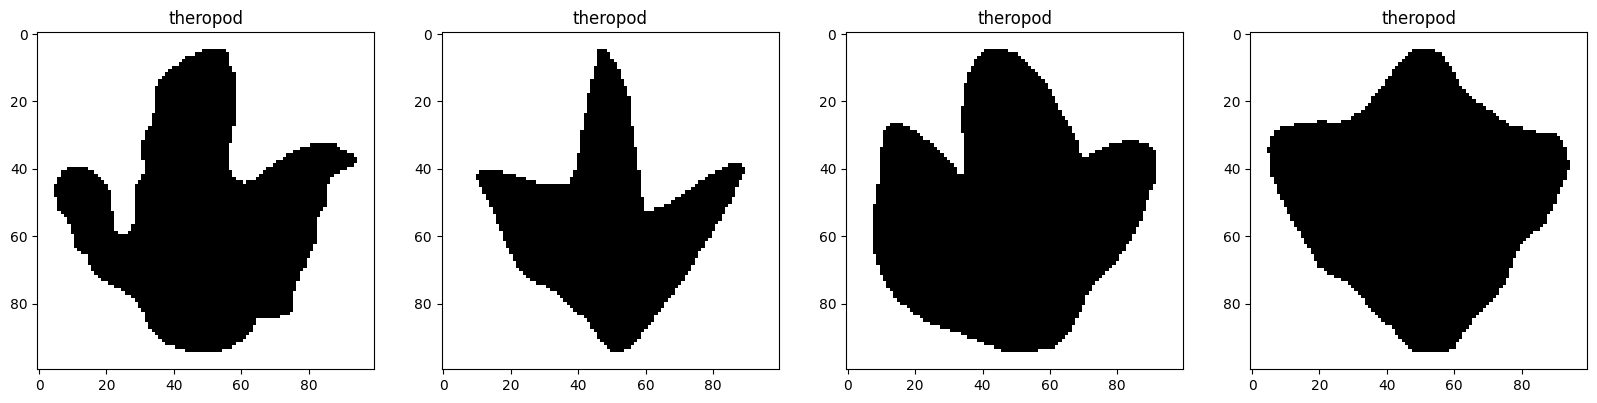

In [ ]:
# this allows to get another batch from our iterator
batch = data_iterator.next()
# have a look at our images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
class_labels = os.listdir(data_dir)  # Define the class labels

for idx, img in enumerate(batch[0][:4]):
    label_index = batch[1][idx]
    class_name = class_labels[label_index]

    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(class_name)

# labels '0' will correspond to 'ornithischian' and labels '1' to 'theropod'

In [ ]:
# reload the dataset
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size = (100,100))

Found 1587 files belonging to 2 classes.


In [ ]:
class_indices = [0, 1]

# Extract labels and features from the dataset
labels = []
features = []

for batch in data:
    features.append(batch[0])
    labels.append(batch[1])

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Reshape the labels to a 1D array
labels = labels.reshape(-1, 1)

# Count the number of samples in each class
class_counts = [np.sum(labels == i) for i in class_indices]

# Calculate the desired number of samples for undersampling
desired_samples = min(class_counts)

# Calculate the undersampling ratios
sampling_ratios = {class_indices[i]: desired_samples for i in range(len(class_indices))}

# Initialize the RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=sampling_ratios, random_state=42)

# Resample the data
resampled_features, resampled_labels = rus.fit_resample(features.reshape(-1, 100 * 100 * 3), labels)

# Reshape the data back to the original shape
resampled_features = resampled_features.reshape(-1, 100, 100, 3)

# Convert labels back to 1D array
resampled_labels = resampled_labels.flatten()

# Create a new tf.data.Dataset for features and labels
resampled_data = tf.data.Dataset.from_tensor_slices((resampled_features, resampled_labels))
unbatched_data = resampled_data.shuffle(buffer_size=len(resampled_labels))

In [ ]:
# Creating empty X and y lists for our images and labels
X = []
y = []

# Iterate through the unbatched dataset
for image, label in unbatched_data:
    image = tf.image.rgb_to_grayscale(image)
    # Process each image and label here
    X.append(image.numpy())  # Append the image to X
    y.append(label.numpy())  # Append the label to y

# Convert lists to NumPy arrays if needed
X = np.array(X)
yield_flat_up_to = np.array(y)

# Check the length of X and Y
print("Length of X:", len(X))
print("Length of y:", len(y))

Length of X: 1216
Length of y: 1216


In [ ]:
# Splitting the dataset into train and test
from sklearn.model_selection import train_test_split

# set % of data to be used for testing
test_size=.20
rnd_seed=42

# and split the dataset accordingly
X_train, X_test, y_train, y_test = train_test_split(
    X, # the source of X data
    y, # the source of y data
    test_size = test_size, # the percent of data to retain as a test
    random_state = rnd_seed,
    stratify=y) # set the random seed - consistent runs are important!

The image should be of a(n) 0


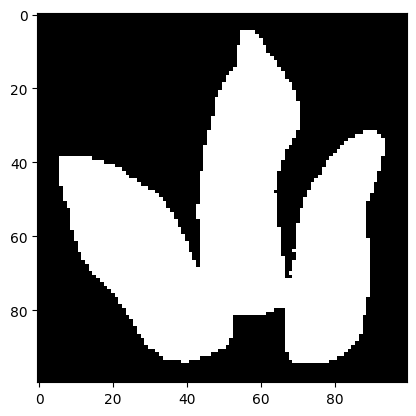

In [ ]:
# Test that the label and image match. We're using np.random instead of our
# rnd_gen since we don't want the runs of this snippet to vary the results in
# other snippets :) Run this as many times as you want!
test = np.random.randint(0,len(X))
plt.imshow(X[test].reshape((100,100)), cmap='Greys')
print(f'The image should be of a(n) {y[test]}')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score
# Flatten each image in X_train and X_test
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

# Create and fit the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train_flat, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred=logreg.predict(X_test_flat)

In [ ]:
# Use score method to get accuracy of model
accuracy = accuracy_score(y_pred, y_test)
f1=f1_score(y_pred,y_test)
recall=recall_score(y_pred,y_test)
print(accuracy)
print(f1)
print(recall)

0.7581967213114754
0.7630522088353414
0.7480314960629921


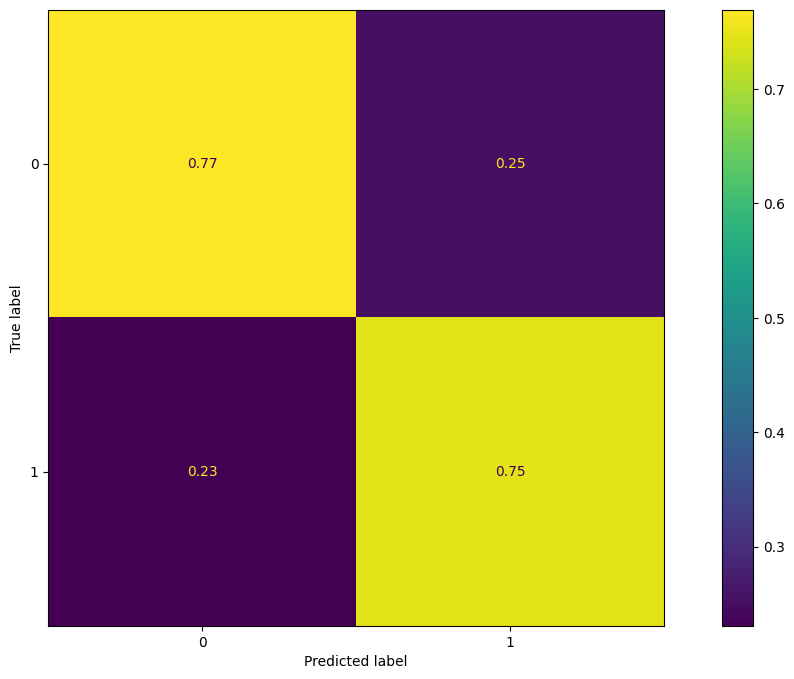

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score,f1_score,recall_score
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='pred')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()